# UniverseMachine Tutorial

### Author: [Peter Behroozi](https://peterbehroozi.com/)

Presented as a tutorial during week 2 of the KITP program, [*Building a Physical Understanding of Galaxy Evolution with Data-driven Astronomy*](https://datadrivengalaxyevolution.github.io/) ([`galevo23`](https://www.kitp.ucsb.edu/activities/galevo23)). See other tutorials [here](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/tree/main/).

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-2/tutorial_on_universemachine/UniverseMachine_Tutorial.ipynb)

# Introduction

The [UniverseMachine](https://arxiv.org/abs/1806.07893) is an empirical model for galaxy formation.  Unlike hydrodynamical or semi-analytical simulations, it uses machine learning to reveal the allowed connections between galaxies and halos.  Using a [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithm, it proposes galaxy-halo connections, generates an entire mock Universe, and compares it to real observations:

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/nIfExFKTWKI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

This is an expensive process, as it requires generating billions of galaxy properties for millions of potential galaxy-halo connections.  Hence, we'll discuss here how to use the output data products, which is what most users will be interested in.  If you're interested in refitting the UniverseMachine to new data, please get in touch.

For many, many use cases, the UniverseMachine [Data Release 1](https://www.peterbehroozi.com/data.html) already has prebuilt data products.  There's a [README](https://bitbucket.org/pbehroozi/universemachine/src/main/#markdown-header-the-universemachine) that lists these, including:
* The input observational constraints (stellar mass functions, specific star formation rates, cosmic star formation rates, correlation functions, quenched fractions, etc.)
* Predictions for all observables up to $z=10$, with JWST-relevant ones available up to [$z=15$](https://arxiv.org/abs/2007.04988).
* Stellar mass / halo mass ratios for all, central, satellite, quenched, star-forming, etc. galaxies as a function of redshift.
* Star formation histories for galaxies binned by host halo mass, host halo circular velocity, or stellar mass.
* Intracluster/intrahalo light fractions.
* Ex-situ/in-situ stellar fractions.
* Quenching statistics for groups and clusters (e.g., quenched fractions, quenching delay times, etc.).
* Lightcones for HST and JWST covering the CANDELS fields.


Since there's already a [README](https://bitbucket.org/pbehroozi/universemachine/src/main/#markdown-header-the-universemachine) covering the prebuilt data files, this tutorial will cover more advanced usage--that is, what you need to know if the prebuilt data files don't include what you need.  We also hope that this will allow more transfer learning, as you can then apply the same techniques for other halo/galaxy catalogues from other simulations.

Today, we'll accomplish everything using the excellent [pandas](https://pandas.pydata.org/) and [scipy](https://scipy.org/)/[numpy](https://numpy.org/) packages.

In [2]:
import numpy as np
from scipy.spatial import KDTree
from scipy.stats import binned_statistic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 16})


You can find UniverseMachine catalogues for a variety of different dark matter halo catalogs:
* Bolshoi-Planck (250 Mpc/h, resolves 10<sup>10</sup> Msun halos).  **Most people will want to use this, unless you have a very specialized need for larger volume or higher resolution.**
* VSMDPL (160 Mpc/h, resolves 10<sup>9</sup> Msun halos).
* SMDPL (400 Mpc/h, resolves 10<sup>10</sup> Msun halos).
* MDPL2 (1 Gpc/h, resolves 10<sup>11</sup> Msun halos).
* Shin-Uchuu (140 Mpc/h, resolves 10<sup>8</sup> Msun halos).
* Uchuu (2 Gpc/h, resolves 10<sup>10.5</sup> Msun halos).

Why use Bolshoi-Planck?  All of these are **enormous** simulations, and you will save yourself many headaches and time by using the smallest data set size that works for your question.  The UniverseMachine output at a single snapshot of Bolshoi-Planck is ~3 GB, which is often just right for analysis on a single machine.  The [UniverseMachine DR1](https://www.peterbehroozi.com/data.html) page has links to most of these simulations, with the [Uchuu](http://skiesanduniverses.org/Simulations/Uchuu/) catalogs available [here](http://skiesanduniverses.org/Simulations/Uchuu/).

# Galaxy / Halo Catalogues

The Bolshoi-Planck simulation evolves a region of the Universe that has a comoving volume of (250 Mpc/h)<sup>3</sup>.  The UniverseMachine then computes galaxy properties for these halos according to the best-fitting presciption that it found for the galaxy-halo connection (i.e., the prescription that best matches observations).  One of the main ways to access the outputs is through the galaxy / halo catalogues.  Each catalogue file corresponds to a snapshot of all the galaxies in this volume and their properties at a given redshift, as well as properties of their host halos.  


##Loading the Data

We'll start off with using the ASCII catalogs for Bolshoi-Planck, available [here](http://halos.as.arizona.edu/UniverseMachine/DR1/SFR_ASCII/).  The lightcones have a very similar format, so much of what is explained here also applies to the lightcones.


Since we want to get to the analysis immediately, we'll download a mini version that is a 50x50x50 (Mpc/h)^3 subregion of the larger volume at *z=0*:

In [3]:
!wget -nv -O mini_sfr_catalog_a1.0.txt http://halos.as.arizona.edu/behroozi/galevo23/sfr_catalog_1.002310.50.50.50.txt

#Uncomment to download the full catalog at z=0
#!wget http://halos.as.arizona.edu/UniverseMachine/DR1/SFR_ASCII/sfr_catalog_1.002310.txt

#If downloading snapshots at other redshifts, note that the number in the filename is the scale factor.
#For example, to download the z=1 (a=0.5) snapshot, you would uncomment:
#!wget http://halos.as.arizona.edu/UniverseMachine/DR1/SFR_ASCII/sfr_catalog_0.501122.txt

2023-01-25 02:13:35 URL:http://halos.as.arizona.edu/behroozi/galevo23/sfr_catalog_1.002310.50.50.50.txt [28291459/28291459] -> "mini_sfr_catalog_a1.0.txt" [1]


Let's take a look at this file.  While there are binary versions of the data files available (see [here](http://halos.as.arizona.edu/UniverseMachine/DR1/SFR/) for the files as well as loaders in C and Python), ASCII is readable by a large number of tools, so it's easy to peek inside:

In [4]:
!head -n40 mini_sfr_catalog_a1.0.txt

#ID DescID UPID Flags Uparent_Dist X Y Z VX VY VZ M V MP VMP R Rank1 Rank2 RA RARank SM ICL SFR obs_SM obs_SFR SSFR SM/HM obs_UV
#UniverseMachine Version: 1.0
#Columns:
#ID: Unique halo ID
#DescID: ID of descendant halo (or -1 at z=0).
#UPID: -1 for central halos, otherwise, ID of largest parent halo
#Flags: Ignore
#Uparent_Dist: Ignore
#X Y Z: halo position (comoving Mpc/h)
#VX VY VZ: halo velocity (physical peculiar km/s)
#M: Halo mass (Bryan & Norman 1998 virial mass, Msun)
#V: Halo vmax (physical km/s)
#MP: Halo peak historical mass (BN98 vir, Msun)
#VMP: Halo vmax at the time when peak mass was reached.
#R: Halo radius (BN98 vir, comoving kpc/h)
#Rank1: halo rank in Delta_vmax (see UniverseMachine paper)
#Rank2, RA, RARank: Ignore
#SM: True stellar mass (Msun)
#ICL: True intracluster stellar mass (Msun)
#SFR: True star formation rate (Msun/yr)
#Obs_SM: observed stellar mass, including random & systematic errors (Msun)
#Obs_SFR: observed SFR, including random & systematic errors (M

First, there's a long header that has column descriptions and units.  Each line after that contains one galaxy and information about its host halo.

Let's call out some of these properties, which are identified in the commented header lines:
* Positions (XYZ coordinates)
* Velocities (relative to the local coordinate patch, not including Hubble flow)
* Halo Masses (spherical overdensities, i.e., Mvir)
* Halo Radii
* True galaxy stellar masses / star formation rates
* Observed galaxy stellar masses / star formation rates

The last two differ because observed star formation rates and stellar masses include random and systematic errors that occur whenever one tries to infer galaxy physical properties (like stellar mass and star formation rates) from their observed SEDs.  The *observed* columns should hence be used whenever you are comparing with observations.  On the other hand, theoretical simulations do not have such errors, and so you should use the *true* columns when comparing with hydro simulations or semi-analytic models.

Let's first load in these data using pandas:

In [5]:
#Routine for extracting information from the commented header lines
def find_in_header(filename, header):
   with open(filename, "r") as f:
     for line in f:
       if line[0:(len(header))]==header:
         return(line[len(header):].split())

#Load in the halos using Pandas, skipping the header rows, except that we'll use the last header line as column labels
#If you use this to load lightcones, change the number of skiprows to be one less than the number of commented lines.
halos = pd.read_csv('mini_sfr_catalog_a1.0.txt', sep='\s+', escapechar='#', skiprows=33)

#If using the full box, it will have fewer header lines, so use this call instead:
#halos = pd.read_csv('sfr_catalog_1.002310.txt', sep='\s+', escapechar='#', skiprows=30)

#Extract the box size from the header
box_size = float(find_in_header('mini_sfr_catalog_a1.0.txt','#Box size:')[0])
print(box_size)

250.0


Although this file is from a 50x50x50 subregion of the larger volume, the box size is still reported as 250 Mpc/h, because this is the relevant number for handling periodic boundary conditions.  So, for example, a galaxy with an X coordinate of 249 Mpc/h is only 1 Mpc/h away along the X axis from a galaxy at an X coordinate of 250 Mpc/h **OR** at an X coordinate of 0 Mpc/h, since the simulation considers 0 and 250 Mpc/h to be the same positions.

Let's take a look at the data itself.

In [6]:
halos

,ID,DescID,UPID,Flags,Uparent_Dist,X,Y,Z,VX,VY,...,RA,RARank,SM,ICL,SFR,obs_SM,obs_SFR,SSFR,SM/HM,obs_UV
0,2809272603,-1,-1,0,2.000000,10.660370,26.128771,22.500900,-43.869999,292.950012,...,-0.716227,-1.428582,4.605000e+11,1.119000e+11,1.110000e+00,4.838000e+11,1.191000e+00,2.461000e-12,3.148000e-03,-18.056
1,132000000407428433,-1,2809272603,8,0.193089,10.640252,26.177111,22.326731,76.539055,426.447510,...,-0.749881,0.654203,3.686000e+08,0.000000e+00,2.056000e-01,4.103000e+08,1.983000e-01,4.833000e-10,2.048000e-02,-16.438
2,135000000342075929,-1,2809272603,8,0.449657,10.897013,26.352448,22.771725,-534.083130,407.248718,...,-0.458897,-0.375855,1.538000e+09,0.000000e+00,7.249000e-03,1.444000e+09,7.973000e-03,5.521000e-12,2.242000e-02,-12.863
3,126000000542313423,-1,2809272603,8,0.213436,10.502553,26.022089,22.565145,-314.848297,567.142273,...,-0.482791,0.303880,1.897000e+10,7.552000e+06,2.170000e-02,1.832000e+10,2.560000e-02,1.397000e-12,1.484000e-02,-14.591
4,130000000451936165,-1,2809272603,8,0.579755,10.919059,26.527370,22.769951,-389.108826,236.317368,...,-2.507083,-1.802981,4.462000e+09,6.235000e+06,2.804000e-04,4.471000e+09,3.063000e-04,6.850000e-14,2.659000e-02,-11.849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109801,2811065224,-1,-1,32,2.000000,45.616299,48.765629,32.012650,-271.070007,122.970001,...,1.357644,-0.173914,4.707000e+02,0.000000e+00,2.235000e-07,3.419000e+02,2.956000e-07,8.646000e-10,1.033000e-06,0.000
109802,2811075043,-1,-1,32,2.000000,46.194118,46.636150,49.315842,28.719999,320.390015,...,1.186552,1.849062,7.254000e+02,0.000000e+00,6.715000e-07,7.999000e+02,7.437000e-07,9.297000e-10,7.958000e-07,0.000
109803,2811075266,-1,-1,32,2.000000,43.388870,46.899551,42.053982,152.479996,610.030029,...,-1.179318,0.731413,1.722000e+03,0.000000e+00,2.298000e-06,2.402000e+03,2.783000e-06,1.159000e-09,1.259000e-06,0.000
109804,29000002404408287,-1,2811077105,8,1.355397,48.376045,49.468967,43.577370,-201.391739,25.254257,...,-1.188002,-1.362933,2.957000e+08,1.759000e+07,9.607000e-05,3.418000e+08,1.421000e-04,4.157000e-13,3.772000e-03,-9.611


Pandas has slurped up the file contents into an array where each row corresponds to a different galaxy and each column corresponds to a different halo/galaxy property.

##Plotting positions

Let's first plot the positions of all the galaxies in the data file.  We'll use the XY positions as the spatial position, and color using the Z coordinate so we can see the 3D structure all at once:

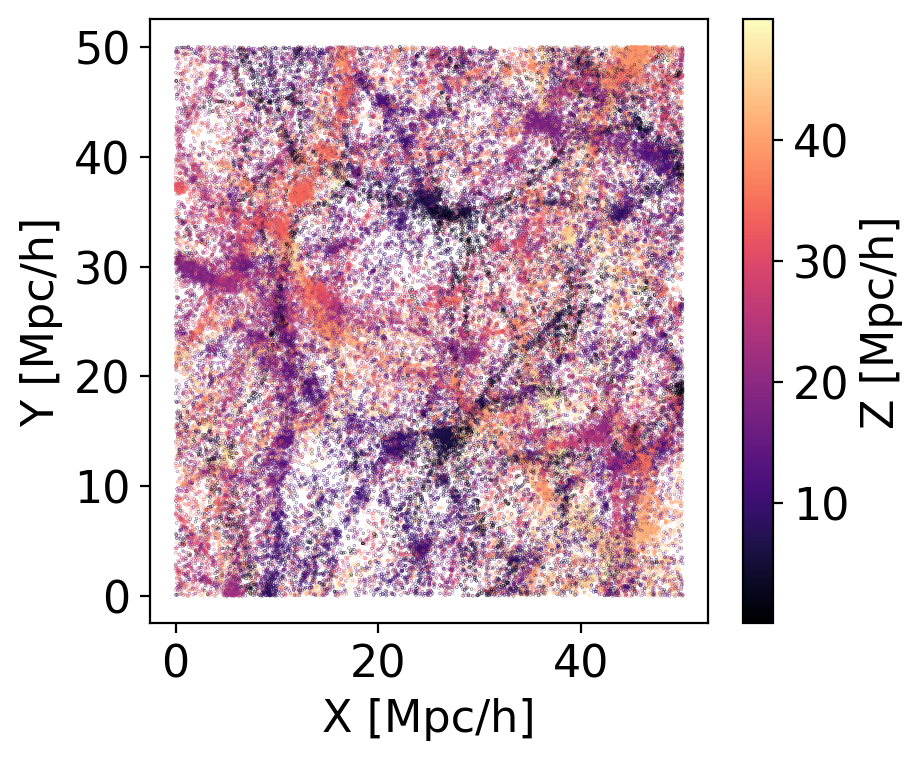

In [7]:
#Plot 2D position using X and Y coordinates, and color code by Z coordinate.
x = halos['X']
y = halos['Y']
z = halos['Z']
cm = sns.color_palette("magma", as_cmap=True)

plt.figure(figsize=(4.5, 4), dpi=200)
sc = plt.scatter(x,y,c=z,s=0.015,cmap=cm)
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.colorbar(sc, label='Z [Mpc/h]')


##Stellar Mass - Halo Mass Relations

The UniverseMachine data release includes many fits to the stellar mass -- halo mass relation for different types of galaxies.  But, if you're interested in exploring these more in depth (e.g., understanding the scatter or investigating different galaxy populations), it's helpful to use the galaxy catalogues.

For example, let's plot the stellar mass / halo mass ratio vs. halo mass, but color code galaxies by their specific star formation rates.

A few bits of data processing are helpful.  The Bolshoi-Planck simulation has finite resolution, so it doesn't provide a complete (fair) sample for halos less massive than 10<sup>10</sup> Msun.  We'll exclude these low-mass halos when plotting the SM/HM relation.  Also, instead of plotting the *current* halo mass, we'll plot the *peak historical* halo mass.  For satellites, which can lose halo mass via tidal fields, this will lead to a tighter SM/HM relationship.

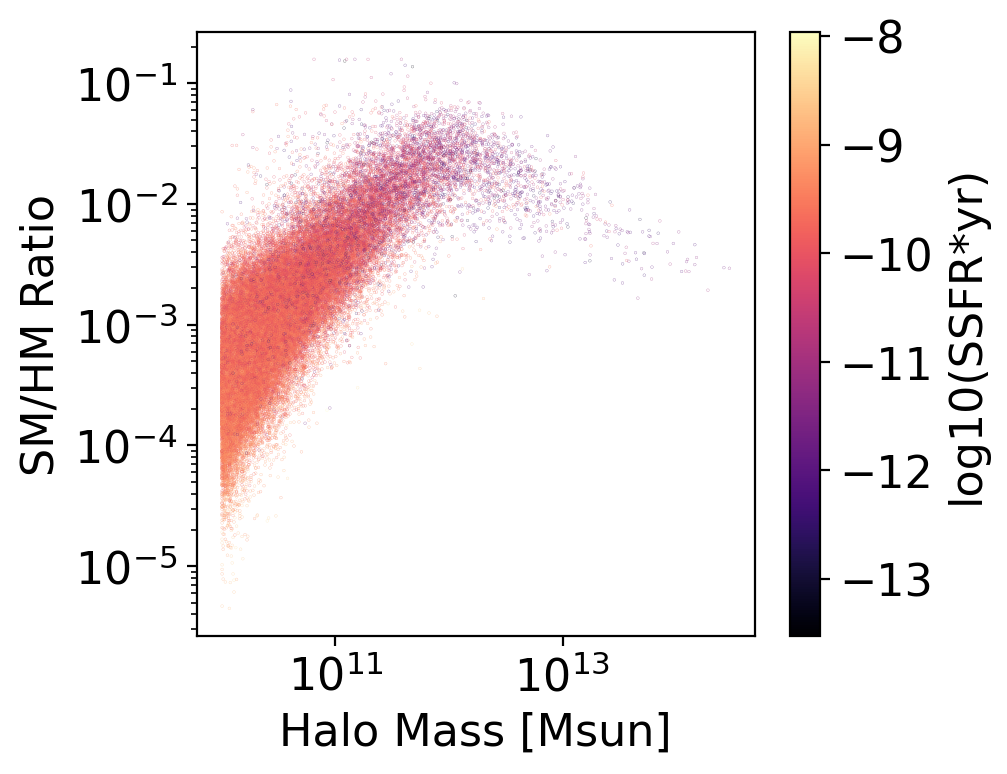

In [8]:
complete_halos = halos[halos['MP']>1e10] #Ignore low-mass halos below Bolshoi-Planck's resolution limit
SMHM = complete_halos['SM/HM']           #We could also divide the SM column by the MP column, but it's already computed for us
HM = complete_halos['MP']                #Use the peak halo mass instead of the current mass
lSSFR = np.log10(complete_halos['SSFR'])

cm=sns.color_palette("magma", as_cmap=True)
plt.figure(figsize=(4.5, 4), dpi=200)
sc = plt.scatter(HM,SMHM,c=lSSFR,s=0.005,cmap=cm)
plt.xlabel('Halo Mass [Msun]')
plt.xscale('log')
plt.ylabel('SM/HM Ratio')
plt.yscale('log')
plt.colorbar(sc, label='log10(SSFR*yr)')


We can already make some interesting science conclusions from this.  At least in the UniverseMachine best-fitting model, there is no strong SM/HM separation between star-forming (SSFR>1e-11/yr) and quenched (SSFR<1e-11/yr) galaxies at fixed halo mass.  However, larger halos tend to host more quiescent galaxies, so the SSFR decreases strongly with increasing halo mass.

Let's also consider central vs. satellite galaxies.  Central galaxies are defined as those galaxies living in *central halos*, which are not contained within any larger halo.  Satellite galaxies, by contrast, live in satellite halos, which orbit inside some larger structure.  We may expect that the conditions for galaxy formation in satellite halos are very different for those in central halos, and we can see this in their SM/HM ratios:

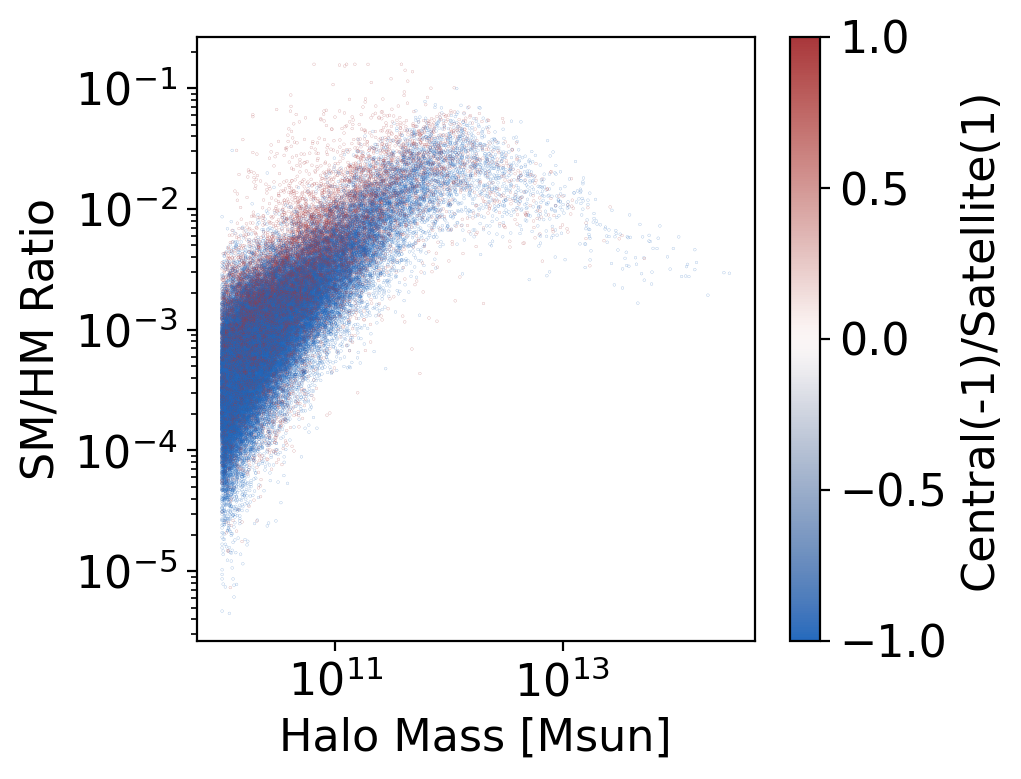

In [9]:
cm = sns.color_palette('vlag', as_cmap=True)

#Central galaxies have UPIDs of -1, and satellites have UPIDs equal to the halo ID of the
# largest central halo that contains them.  The following command then quickly collapses the
# UPID distribution to a value that is -1 for central galaxies and 1 for satellites.
CS = np.sign(complete_halos['UPID'])

plt.figure(figsize=(4.5, 4), dpi=200)
sc = plt.scatter(HM,SMHM,c=CS,s=0.003,cmap=cm)
plt.xlabel('Halo Mass [Msun]')
plt.xscale('log')
plt.ylabel('SM/HM Ratio')
plt.yscale('log')
plt.colorbar(sc, label='Central(-1)/Satellite(1)')




##Generic parameters

We can of course plot any combination of parameters in this way.  For example, another key plot is SSFR vs. SM:

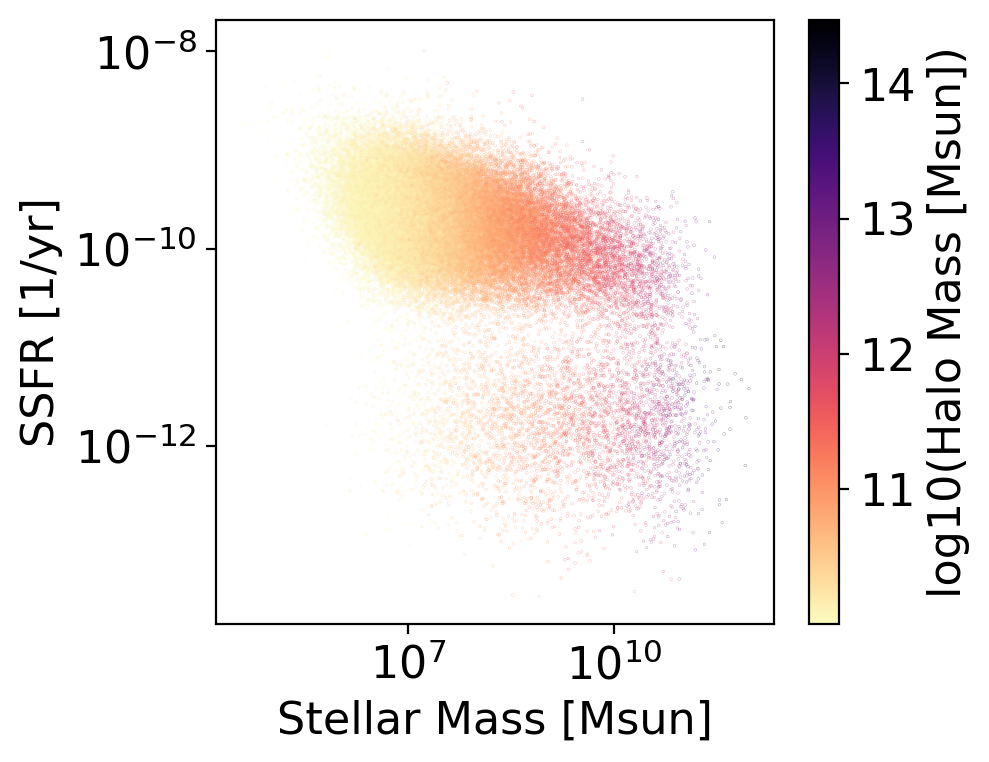

In [10]:
SM = complete_halos['obs_SM']           #We'll use observed SM, for consistency with the SSFR column
SSFR = complete_halos['SSFR']
lHM = np.log10(complete_halos['MP'])  #We'll color by halo mass

cm=sns.color_palette("magma_r", as_cmap=True)
plt.figure(figsize=(4.5, 4), dpi=200)
sc = plt.scatter(SM,SSFR,c=lHM,s=0.005,cmap=cm)
plt.xlabel('Stellar Mass [Msun]')
plt.xscale('log')
plt.ylabel('SSFR [1/yr]')
plt.yscale('log')
plt.colorbar(sc, label='log10(Halo Mass [Msun])')


**Exercise**
- Pick another two parameters, for example SSFR and intracluster light (ICL), and color code vs. a third parameter (e.g., halo mass or SM/HM).  Does it make sense?

##Using Spatial Information

A common reason to need the UniverseMachine catalogues is to study galaxies in and around clusters.  For this purpose, it's very useful to use [kd-trees](https://en.wikipedia.org/wiki/K-d_tree), which are a data structure that allows fast access to spatially nearby objects.  SciPy comes with built-in tools to handle these, i.e., [scipy.spatial.KDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html).  Using this is as simple as giving SciPy an array of 3D (or 2D) positions:

In [11]:
#Here, box_size signals to KDTree that we have periodic boundary conditions
tree = KDTree(np.array(complete_halos[['X','Y','Z']]), boxsize=box_size)

Next, let's visualize the distribution of galaxies near clusters, which we'll define here as halos with masses greater than 10<sup>14</sup> Msun (~100x the mass of the Milky Way's halo).  We'll color code by specific star formation rates -- motivated by the fact that cluster cores tend to have more quiescent galaxies.  KDTree has a method to query for neighbors within a certain distance (``query_ball_point()``), which returns a list of indices of the neighbors in the original list of positions passed to the tree setup above.

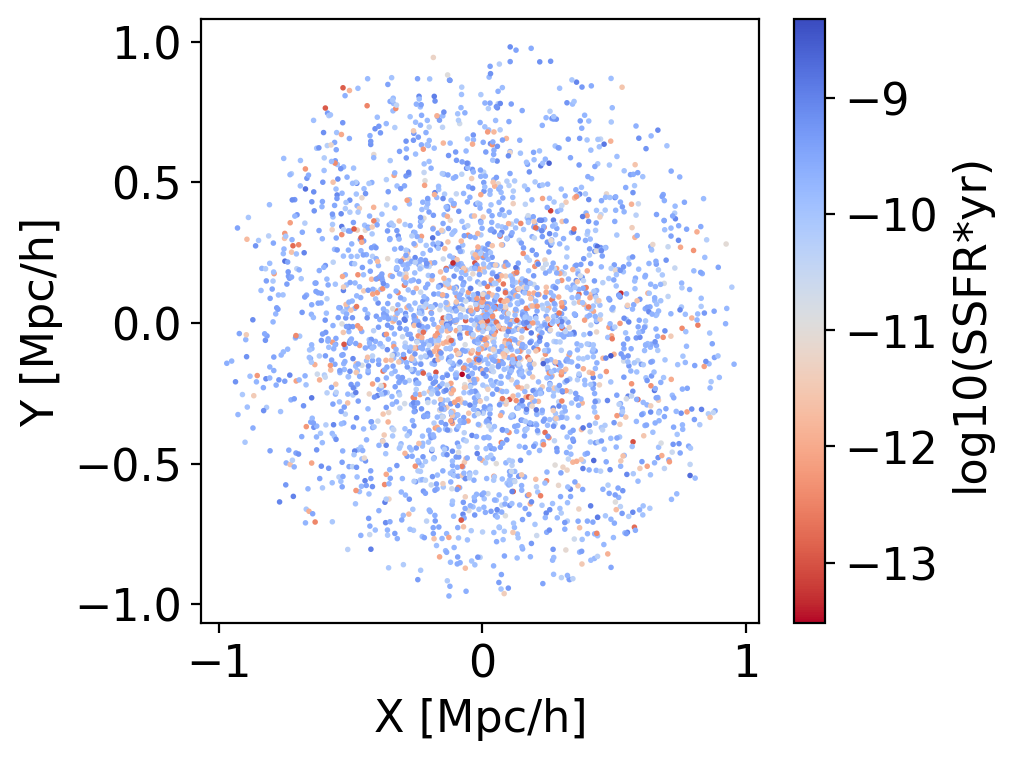

In [12]:
def periodic_distance(distances):
  return ((distances+box_size/2)%box_size - box_size/2)

#Select clusters and convert their locations to numpy arrays
large_halos = complete_halos[complete_halos['MP']>1e14]
large_halo_locations = np.array(large_halos[['X','Y','Z']])
large_halo_velocities = np.array(large_halos[['VX','VY','VZ']])

#create a new pandas structure with the same columns to store neighboring galaxies
large_halo_neighbors = pd.DataFrame(columns=complete_halos.columns)

#loop over the clusters, using a kd-tree query to find the nearby galaxies
for i in range(len(large_halos)):
  neighbor_ids = tree.query_ball_point(large_halo_locations[i], 1) #selects halos within 1 Mpc/h

  #We want to plot the neighboring galaxies according to their distance relative to
  #  cluster centers, so we'll copy the data and subtract the cluster position and
  #  velocity center from each galaxy in the code below:
  neighbors = complete_halos.iloc[neighbor_ids].copy(deep=True)
  neighbors['X']=periodic_distance(neighbors['X']-large_halo_locations[i][0])
  neighbors['Y']=periodic_distance(neighbors['Y']-large_halo_locations[i][1])
  neighbors['Z']=periodic_distance(neighbors['Z']-large_halo_locations[i][2])
  neighbors['VX']-=large_halo_velocities[i][0]
  neighbors['VY']-=large_halo_velocities[i][1]
  neighbors['VZ']-=large_halo_velocities[i][2]
  large_halo_neighbors = pd.concat([large_halo_neighbors,neighbors])

#Finally, we plot the neighbors according to their X and Y offsets from
#  cluster centers, and color code by log SSFR
lx = large_halo_neighbors['X']
ly = large_halo_neighbors['Y']
llSSFR = np.log10(large_halo_neighbors['SSFR'])
cm = sns.color_palette('coolwarm_r', as_cmap=True)

plt.figure(figsize=(4.5, 4), dpi=200)
sc = plt.scatter(lx,ly,c=llSSFR,s=1,cmap=cm)
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.colorbar(sc, label='log10(SSFR*yr)')


So we see that quenched galaxies are indeed found closer to the center of the cluster.

Since we have velocity information, we can also look at quenching in *phase space*, i.e., some combination of both position and velocity-space.  For simulations, this is often chosen to be velocity offset vs. (3D) radial distance from the cluster center, whereas for observations, it's often the line-of-sight velocity vs. projected distance.  We'll plot quenching in simulation phase-space, since it's cleaner to see:

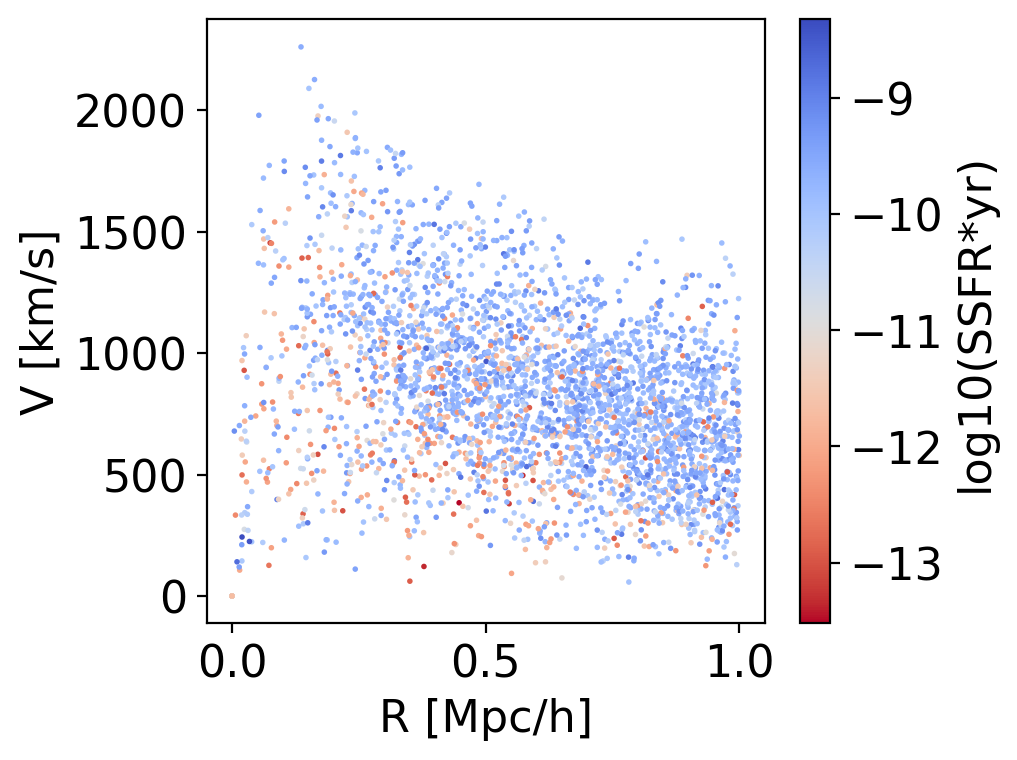

In [13]:
#Compute neighbor distances from cluster centers, both in velocity and position space
neighbor_distances = np.sqrt(large_halo_neighbors['X']**2 + large_halo_neighbors['Y']**2 + large_halo_neighbors['Z']**2)
neighbor_velocities = np.sqrt(large_halo_neighbors['VX']**2 + large_halo_neighbors['VY']**2 + large_halo_neighbors['VZ']**2)

#Here's how you would compute radial velocity, if you wanted that instead
neighbor_radial_velocities = (large_halo_neighbors['X']*large_halo_neighbors['VX']+
                              large_halo_neighbors['Y']*large_halo_neighbors['VY']+
                              large_halo_neighbors['Z']*large_halo_neighbors['VZ'])/neighbor_distances

cm = sns.color_palette('coolwarm_r', as_cmap=True)
plt.figure(figsize=(4.5, 4), dpi=200)
sc = plt.scatter(neighbor_distances,neighbor_velocities,c=llSSFR,s=1,cmap=cm)
plt.xlabel('R [Mpc/h]')
plt.ylabel('V [km/s]')
plt.colorbar(sc, label='log10(SSFR*yr)')

The science here is interesting--quenched galaxies live both at lower relative distances *and* lower relative velocities, which is because larger velocities often indicate more recent time since satellite infall.

Let's turn these scatter plots into something a bit more quantitative, by binning the average SSFR and quenched fractions, using SciPy's [binned_statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html).

First, average SSFRs:

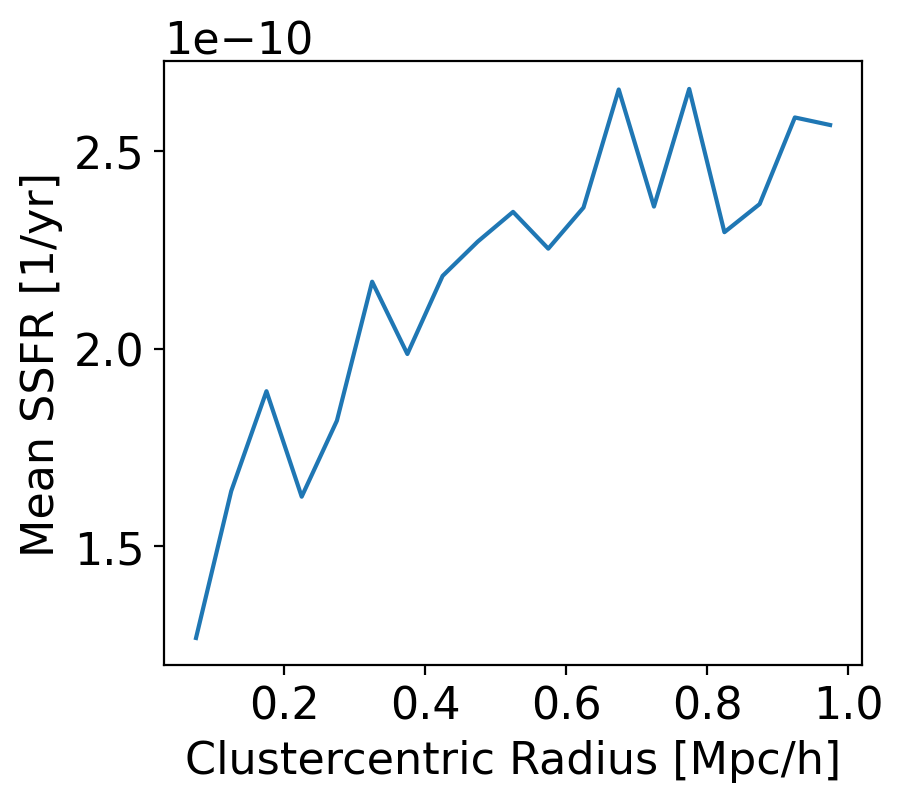

In [14]:
mean_ssfr,bins,bn = binned_statistic(neighbor_distances, 10**llSSFR, bins=20)
bin_centers = [0.5*(bins[x]+bins[x+1]) for x in range(len(bins)-1)]

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('Clustercentric Radius [Mpc/h]')
plt.ylabel('Mean SSFR [1/yr]')
sc = plt.plot(bin_centers[1:],mean_ssfr[1:]) #Ignore central galaxies in bin 0


Next, quenched fractions.  Here, it's a bit more complex, as we have to write a two-line function to classify galaxies as star-forming or quenched.

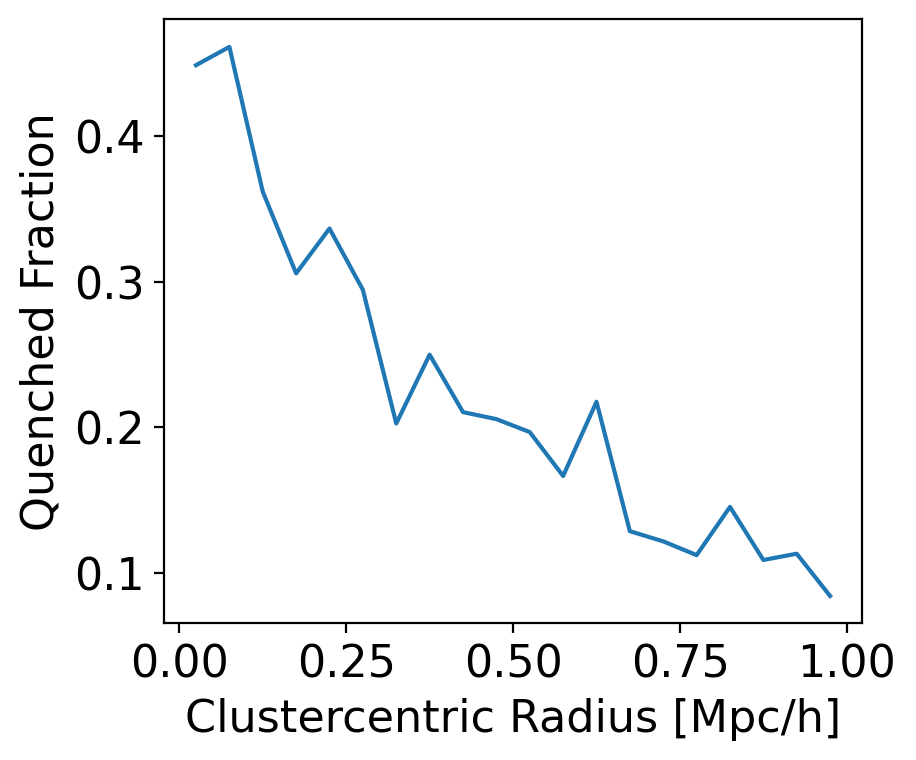

In [15]:
def quenched_fraction(ssfrs):
  q=len(ssfrs[ssfrs<1e-11])  #This calculates the number of quenched galaxies
  return q/len(ssfrs)        #So we divide by the total number of galaxies to get the quenched fraction

quenched,bins,bn = binned_statistic(neighbor_distances, 10**llSSFR, statistic=quenched_fraction, bins=20)
bin_centers = [0.5*(bins[x]+bins[x+1]) for x in range(len(bins)-1)]

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('Clustercentric Radius [Mpc/h]')
plt.ylabel('Quenched Fraction')
sc = plt.plot(bin_centers,quenched)

So we can see that quenched fractions are significantly higher at low clustercentric radii.  

**Exercises:**
* Convert all the code above to use observed space quantities--i.e., projected distance and line-of-sight radius.  Are the trends above still detectable?
* Implement a lower stellar mass threshold of 10<sup>10</sup> Msun.  Does it make sense how the quenched fractions change?

#Star Formation Histories

The other major component of UniverseMachine outputs are star formation history files.  Since these contain the halo and galaxy growth histories across all previous snapshots, the amount of data is much larger, and the catalogues are only available at specific redshifts.  If you need other redshifts, talk to me!

We'll work with a downsampled (20%) version of one subregion at a higher redshift just so that the data sizes are relatively small.

In [16]:
!wget -nv -O mini_sfh_catalog_a0.33.txt http://halos.as.arizona.edu/behroozi/galevo23/mini_sfh_catalog.txt

2023-01-25 02:19:00 URL:http://halos.as.arizona.edu/behroozi/galevo23/mini_sfh_catalog.txt [35360180/35360180] -> "mini_sfh_catalog_a0.33.txt" [1]


##Loading the data:

Let's take a look at this file as well:

In [17]:
!head -n20 mini_sfh_catalog_a0.33.txt

#ID UPID X Y Z VX VY VZ Mpeak Mnow V@Mpeak Vnow Rvir Tidal_Tdyn Rank_DVmax(Z-score) Random_Rank(Z-score) SM ICL SFR Obs_SM Obs_SFR Obs_UV A_first_infall A_last_infall SFH(1..num_scales) ICLH(1..num_scales) SM_main_progenitor(1..num_scales) ICL_main_progenitor(1..num_scales) M_main_progenitor(1..num_scales) SFR_main_progenitor(1..num_scales) V@Mpeak(1..num_scales) Rank_DVmax(Z-score;1..num_scales)
#a = 0.334060
#Units: all masses in Msun (no h).
#Units: all velocities in km/s (physical, not comoving).
#Units: Rvir in kpc/h comoving.
#num_scales: 67
#scale list: 0.055623 0.060123 0.062373 0.064623 0.066873 0.069123 0.071373 0.073623 0.075873 0.078123 0.080373 0.082623 0.085998 0.089373 0.092748 0.096123 0.099498 0.102873 0.106248 0.109623 0.112998 0.116373 0.119748 0.123123 0.126498 0.129873 0.133248 0.136623 0.141685 0.146748 0.151810 0.156873 0.161935 0.166998 0.172060 0.177123 0.182185 0.187248 0.192310 0.197373 0.202435 0.207498 0.212560 0.217623 0.222685 0.227748 0.232810 0.237873 0

The format is very similar to the format for the main galaxy catalogues, with one galaxy per line.  However, at the end we have a series of lists that contain the total star formation histories, total intracluster light histories, main-progenitor stellar mass and ICL histories, and main-progenitor halo mass and SFR histories.  The main progenitor histories cover the properties of the most-massive galaxy progenitor at earlier times, whereas the first two lists contain when the present-day stellar populations were formed (i.e., including mass contributed via mergers).

We'll need to do a little bit of extra coding to load in all these lists sensibly.

In [18]:
sfh_file = 'mini_sfh_catalog_a0.33.txt'

#list of scale factors for simulation snapshots.  There will be one history entry (SFR, ICL, etc.) for every scale factor.
scales = np.array(find_in_header(sfh_file,'#scale list:')).astype('float')
short_column_labels = find_in_header(sfh_file,'#')
print(short_column_labels)

['ID', 'UPID', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'Mpeak', 'Mnow', 'V@Mpeak', 'Vnow', 'Rvir', 'Tidal_Tdyn', 'Rank_DVmax(Z-score)', 'Random_Rank(Z-score)', 'SM', 'ICL', 'SFR', 'Obs_SM', 'Obs_SFR', 'Obs_UV', 'A_first_infall', 'A_last_infall', 'SFH(1..num_scales)', 'ICLH(1..num_scales)', 'SM_main_progenitor(1..num_scales)', 'ICL_main_progenitor(1..num_scales)', 'M_main_progenitor(1..num_scales)', 'SFR_main_progenitor(1..num_scales)', 'V@Mpeak(1..num_scales)', 'Rank_DVmax(Z-score;1..num_scales)']


In [19]:

#We'll expand the column labels with 1..num_scales so that we can access them in pandas.
#As well, we'll record the positions of each type of history (SFR, ICL, etc.) so that we can access easily later
full_column_labels = []
column_indices = {}
for x in short_column_labels:
  offset=x.find('1..num_scales')
  if (offset>-1):
    column_indices[x[0:(offset-1)]]=len(full_column_labels)
    for a in scales:
      full_column_labels.append(x[0:offset]+str(a)+')')
  else:
    full_column_labels.append(x)

#Print out the full list of column labels, as well as the positions of the beginning of each history list
print(full_column_labels)
print(column_indices)

['ID', 'UPID', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'Mpeak', 'Mnow', 'V@Mpeak', 'Vnow', 'Rvir', 'Tidal_Tdyn', 'Rank_DVmax(Z-score)', 'Random_Rank(Z-score)', 'SM', 'ICL', 'SFR', 'Obs_SM', 'Obs_SFR', 'Obs_UV', 'A_first_infall', 'A_last_infall', 'SFH(0.055623)', 'SFH(0.060123)', 'SFH(0.062373)', 'SFH(0.064623)', 'SFH(0.066873)', 'SFH(0.069123)', 'SFH(0.071373)', 'SFH(0.073623)', 'SFH(0.075873)', 'SFH(0.078123)', 'SFH(0.080373)', 'SFH(0.082623)', 'SFH(0.085998)', 'SFH(0.089373)', 'SFH(0.092748)', 'SFH(0.096123)', 'SFH(0.099498)', 'SFH(0.102873)', 'SFH(0.106248)', 'SFH(0.109623)', 'SFH(0.112998)', 'SFH(0.116373)', 'SFH(0.119748)', 'SFH(0.123123)', 'SFH(0.126498)', 'SFH(0.129873)', 'SFH(0.133248)', 'SFH(0.136623)', 'SFH(0.141685)', 'SFH(0.146748)', 'SFH(0.15181)', 'SFH(0.156873)', 'SFH(0.161935)', 'SFH(0.166998)', 'SFH(0.17206)', 'SFH(0.177123)', 'SFH(0.182185)', 'SFH(0.187248)', 'SFH(0.19231)', 'SFH(0.197373)', 'SFH(0.202435)', 'SFH(0.207498)', 'SFH(0.21256)', 'SFH(0.217623)', 'SFH(0.222685)', 

Now we can load the data using pandas with our list of column names:

In [20]:
halo_sfh = pd.read_csv(sfh_file, sep='\s+', comment='#', names=full_column_labels)
halo_sfh = halo_sfh[halo_sfh['Mpeak']>1e10] #Limit to complete halos for Bolshoi-Planck
halo_sfh

,ID,UPID,X,Y,Z,VX,VY,VZ,Mpeak,Mnow,...,Rank_DVmax(Z-score;0.288498),Rank_DVmax(Z-score;0.29356),Rank_DVmax(Z-score;0.298623),Rank_DVmax(Z-score;0.303685),Rank_DVmax(Z-score;0.308748),Rank_DVmax(Z-score;0.31381),Rank_DVmax(Z-score;0.318873),Rank_DVmax(Z-score;0.323935),Rank_DVmax(Z-score;0.328997),Rank_DVmax(Z-score;0.33406)
0,21000000407428433,883197229,10.24170,24.67880,26.4834,186.8610,14.0860,-339.637,1.800000e+10,4.354560e+09,...,-0.481918,-0.501147,-0.486297,-0.477491,-0.467485,-0.459371,-0.524085,-0.615562,-0.690345,-0.692289
1,27000000279341210,883197229,10.36430,25.21730,26.7236,-15.6142,-110.8860,-265.211,2.475000e+11,1.856620e+10,...,-1.502670,-1.527650,-1.553300,-1.584220,-1.589360,-1.582790,-1.562370,-1.555450,-1.542950,-1.529570
2,22000000385430261,883197229,10.33190,25.44690,26.8610,-24.2803,42.6727,-246.176,2.416180e+10,2.060940e+09,...,-1.518840,-1.539550,-1.575200,-1.612280,-1.648920,-1.700380,-1.697690,-1.690680,-1.683180,-1.672770
3,883197318,883197317,9.69826,24.81840,24.8086,99.9600,340.3000,127.570,1.093820e+10,5.925000e+09,...,-1.239930,-1.385210,-0.859160,-1.358050,-1.296860,-1.306350,-1.244870,-0.992182,-1.120140,-1.085820
4,883197332,883197229,10.56750,24.73500,26.1192,253.5100,453.0300,-556.240,1.982350e+10,5.697060e+09,...,0.820512,-0.667241,-0.457003,-0.529149,-0.941710,-0.922522,-1.166460,-1.367280,-1.348980,-1.102480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11239,900940544,-1,1.72234,2.44871,210.8800,-132.9300,-138.6000,-293.380,2.757350e+10,2.552940e+10,...,1.056080,0.931978,0.672290,0.336790,0.171125,0.048182,-0.494630,-0.478809,-0.637271,-0.667439
11240,900940546,-1,1.24741,2.22865,209.9220,-82.0100,-196.7600,-185.290,1.071030e+10,7.064710e+09,...,0.001517,0.274877,0.134444,-0.419009,-0.404049,-0.637558,-0.896570,-1.174470,-1.292230,-1.321230
11241,900954627,-1,-1.46817,15.01450,220.4160,104.6300,-68.9600,-167.100,1.390150e+10,1.344560e+10,...,1.298450,0.796929,0.764624,0.971478,0.837238,0.760425,0.527774,0.584234,-0.001192,-0.017693
11242,900950387,-1,3.32096,18.50180,202.4750,-243.1200,29.5800,-93.910,6.358820e+10,6.198530e+10,...,0.481500,0.193119,0.727136,0.968686,1.081240,1.303880,1.374270,1.388870,1.214920,1.229870


##Plotting Galaxy Evolutionary Histories

We can now pull out separate pandas dataframes for the specific galaxy / halo growth histories that interest us.  Let's do this for the total population star formation history, as well as the main-progenitor halo mass, stellar mass, and SFR.  This way, we can compute SM/HM ratio histories, as well as SSFR histories.

Just as a sanity check, we'll pull out the first star formation history and plot it.

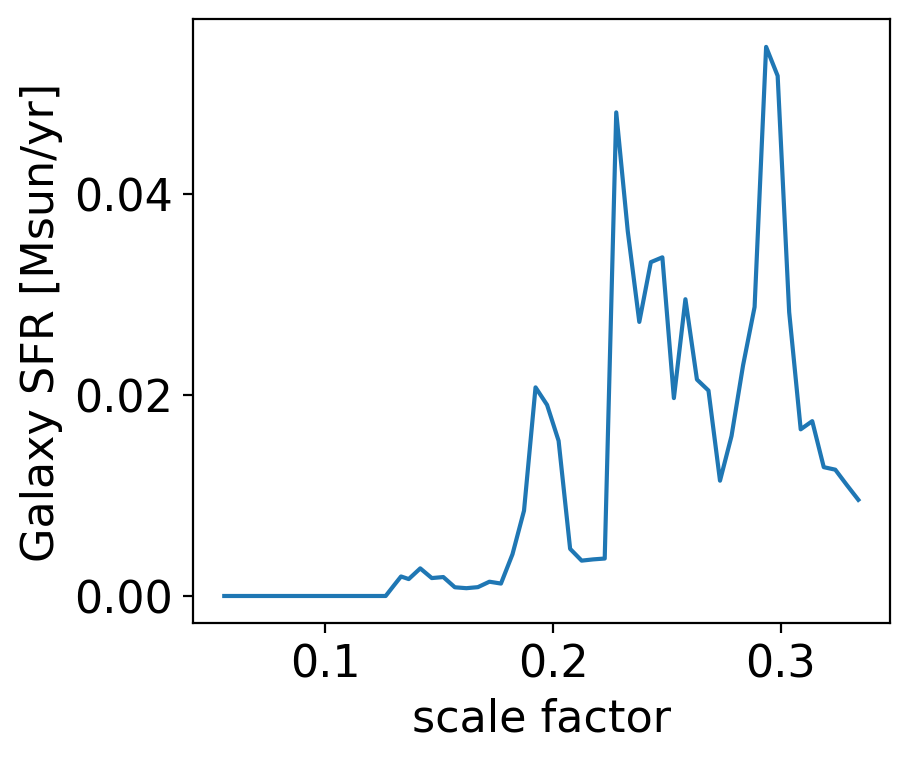

In [21]:
#Total star-formation histories
SFHs = halo_sfh.iloc[:, range(column_indices['SFH'],column_indices['SFH']+len(scales))]

#main-progenitor halo masses
MHs = halo_sfh.iloc[:, range(column_indices['M_main_progenitor'],column_indices['M_main_progenitor']+len(scales))]

#main-progenitor stellar masses
SMHs = halo_sfh.iloc[:, range(column_indices['SM_main_progenitor'],column_indices['SM_main_progenitor']+len(scales))]

#main-progenitor star formation rates
SFRHs = halo_sfh.iloc[:, range(column_indices['SFR_main_progenitor'],column_indices['SFR_main_progenitor']+len(scales))]


#main-progenitor SM/HM relations
SMHMs = SMHs/(np.array(MHs))
SMHMs.fillna(0, inplace=True) #Replaces NaNs with 0s

#main-progenitor SSFRs
SSFRHs = SFRHs/(np.array(SMHs))
SSFRHs.fillna(0, inplace=True) #Replaces NaNs with 0s

#Now we'll take a look at the first star formation history
plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('scale factor')
plt.ylabel('Galaxy SFR [Msun/yr]')
plt.plot(scales,SFHs.iloc[0])

What are these arrays that we've pulled out?  Each one contains a list of numbers for every *z=2$ galaxy in the star formation history file.  Each galaxy's list contains one number per simulation snapshot, corresponding to the property of the galaxy in question at the given snapshot.  The snapshot scale factors are stored in the ``scales`` array, so we can plot anything vs. scale factor as in the code block above.

With these data in hand, it's straightforward to plot how galaxies evolve without tracing through halo merger trees through time.  Let's first demonstrate, for example, how galaxies move in their stellar mass / halo mass ratios over time.

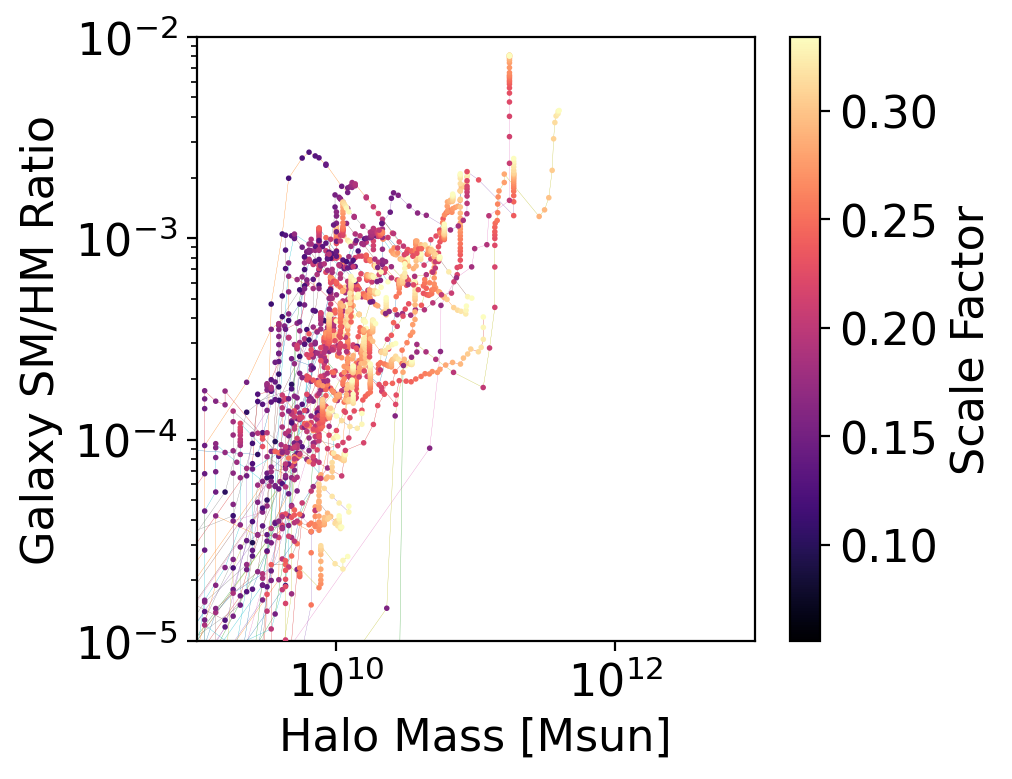

In [22]:
cm=sns.color_palette("magma", as_cmap=True)

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('Halo Mass [Msun]')
plt.ylabel('Galaxy SM/HM Ratio')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e9,1e13)
plt.ylim(1e-5,1e-2)

#We'll pick 50 random galaxies, so this plot will be different every time
for i in range(0,50):
  index = np.random.randint(0,len(MHs))
  sc = plt.scatter(MHs.iloc[index], SMHMs.iloc[index], s=1, c=scales, cmap=cm, zorder=10)
  plt.plot(MHs.iloc[index], SMHMs.iloc[index], linewidth=0.1)
plt.colorbar(sc, label='Scale Factor')

We see lots of ups and downs in the plot above.  The SM/HM ratio goes down when halo mass specific growth rates are faster than galaxy mass specific growth rates; vice versa, it goes up when galaxy stellar mass is growing relatively faster than halo mass.

If we're interested in a more observable space, we can examine how galaxies evolve in the specific star formation rate vs. stellar mass plane:



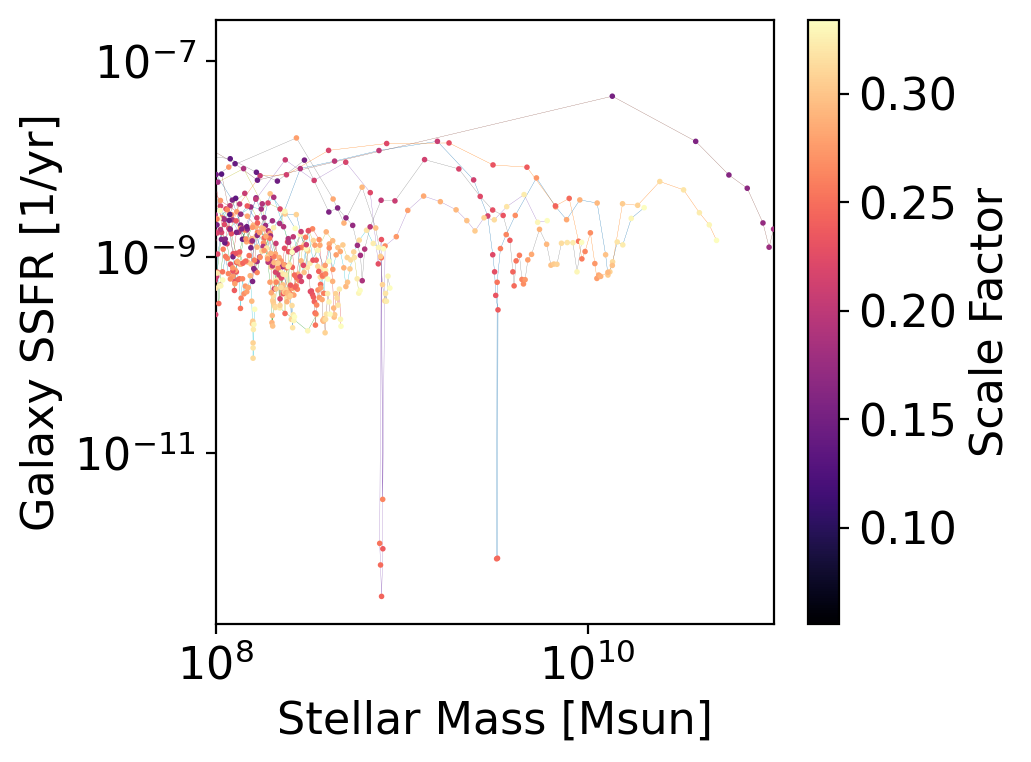

In [24]:
cm=sns.color_palette("magma", as_cmap=True)

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('Stellar Mass [Msun]')
plt.ylabel('Galaxy SSFR [1/yr]')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e8,1e11)

#We'll pick 200 galaxies, since most will be low-mass (too small to be observed)
for i in range(0,200):
  index = np.random.randint(0,len(SMHs))
  sc = plt.scatter(SMHs.iloc[index], SSFRHs.iloc[index], s=1, c=scales, cmap=cm, zorder=10)
  plt.plot(SMHs.iloc[index], SSFRHs.iloc[index], linewidth=0.1)
plt.colorbar(sc, label='Scale Factor')

If we run this enough times, we should find several galaxies that have brief periods of quenching followed by rejuvenation.  Once in a while, there will be a galaxy that quenches and then loses mass through passive stellar evolution.  If we followed the trajectories of such galaxies to *z=0$, we would find that some gained mass even with low SSFRs, which occurs via galaxy mergers.

##Using Spatial Information

Moving on to other useful science cases, many folks are interested in studying protoclusters at higher redshifts.  There are a large number of definitions, but a simple one is to use massive halos (here, we'll use halos with M>10<sup>12.5</sup> Msun).

As before, we'll build a kd-tree using the spatial information in the star formation histories file and search for neighboring galaxies around protoclusters.

One wrinkle is that the spatial positions in the star formation histories are not pre-wrapped to the box boundaries (0-250 Mpc/h for Bolshoi-Planck), but that's easy to fix using pandas.

In [25]:
def wrap(positions):
  return ((positions+box_size)%box_size)

#Wrap halo positions to fall within 0-box_size
halo_sfh['X']=wrap(halo_sfh['X'])
halo_sfh['Y']=wrap(halo_sfh['Y'])
halo_sfh['Z']=wrap(halo_sfh['Z'])

#We'll use 10^12.5 Msun as our threshold mass for protoclusters--in practice,
# you would want to use a larger number like 10^13 or 10^13.5, but we're using
# a very tiny subregion of the box for this demo.
protoclusters = halo_sfh[halo_sfh['Mpeak']>3e12]
protocluster_locations = np.array(protoclusters[['X','Y','Z']])

In [26]:
tree_sfh = KDTree(np.array(halo_sfh[['X','Y','Z']]), boxsize=box_size)

Now that we've built the tree, we can find protocluster neighbors and plot their mean star formation histories, compared to all galaxies:

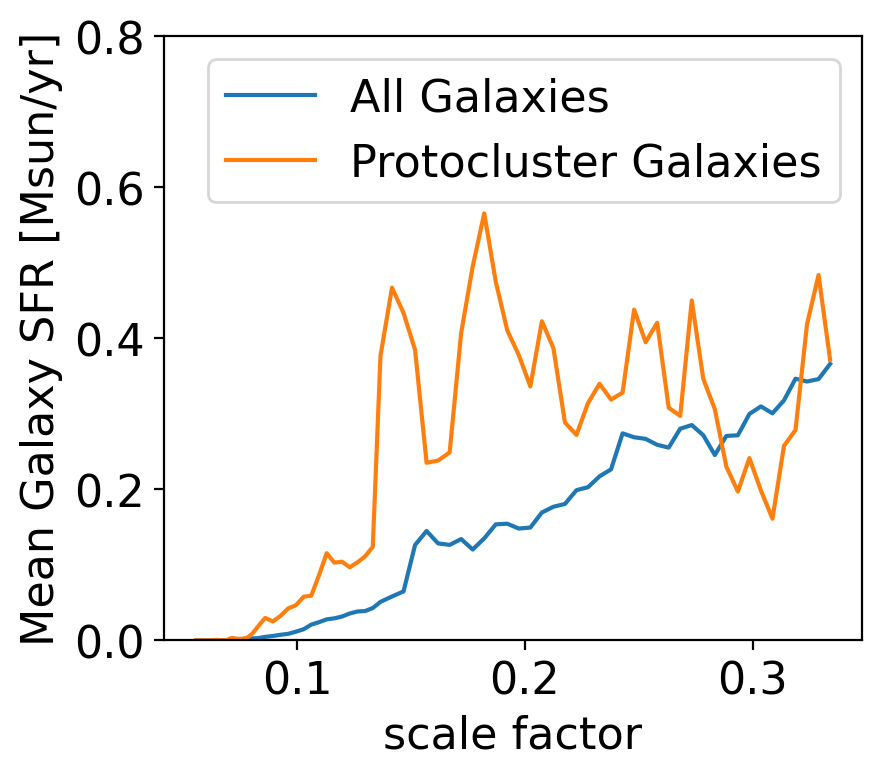

In [27]:
#This is a messy call--the query_ball_point will return all neighbors of protoclusters,
# but we want to exclude the central galaxies of protoclusters, since we're interested in
# how the protocluster environment affects star formation in nearby galaxies.
# Hence, the if statement at the end excludes central galaxies in the protoclusters.
#The double list construct syntax (x for list in query for x in list) flattens the list of lists
# returned by query_ball_point into a single list of all the neighbor indexes. 
protocluster_neighbor_ids = [x for list in tree_sfh.query_ball_point(protocluster_locations, 2) for x in list if halo_sfh.iloc[x]['Mpeak']<3e12]

#Once we have the neighbors, we can get their average SFH
average_sfh_near_protoclusters = SFHs.iloc[protocluster_neighbor_ids].mean()

#As well as the average SFH of all galaxies
average_sfh = SFHs.mean()

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('scale factor')
plt.ylabel('Mean Galaxy SFR [Msun/yr]')
plt.ylim(0,0.8)
plt.plot(scales,average_sfh, label='All Galaxies')
plt.plot(scales,average_sfh_near_protoclusters, label='Protocluster Galaxies')
plt.legend()


We find that galaxies near protoclusters had earlier typical star formation histories.  Why is this?  We can also look at their halo growth histories:

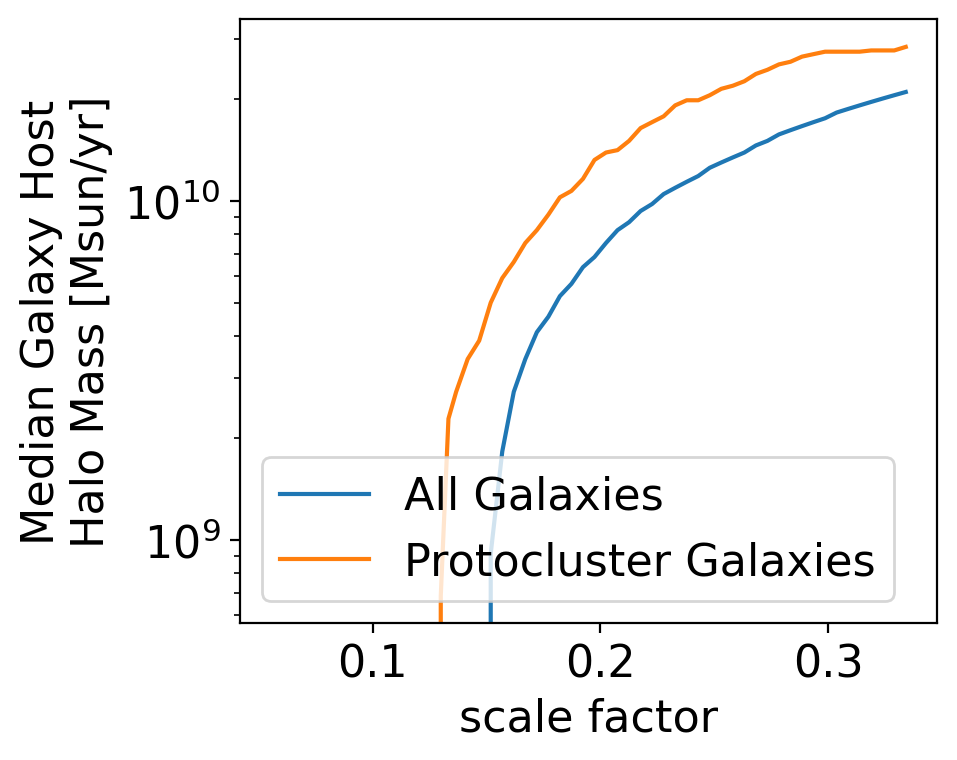

In [28]:
median_mh_near_protoclusters = MHs.iloc[protocluster_neighbor_ids].median()
median_mh = MHs.median()

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('scale factor')
plt.ylabel('Median Galaxy Host\nHalo Mass [Msun/yr]')
plt.yscale('log')
plt.plot(scales,median_mh, label='All Galaxies')
plt.plot(scales,median_mh_near_protoclusters, label='Protocluster Galaxies')
plt.legend()

Aha!  So the typical host halo mass of protocluster neighbors also is higher, which makes sense: we can think of overdense regions as collapsing and growing on a more accelerated timescale than the rest of the Universe.

We can also of course choose any other statistic of our liking:

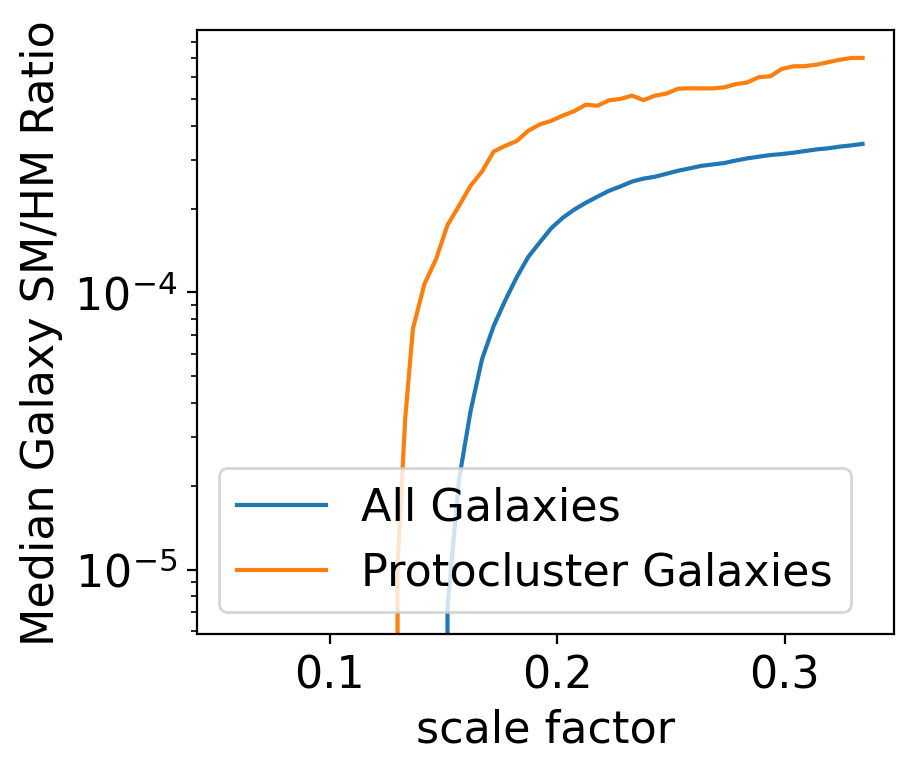

In [29]:
median_smhm_near_protoclusters = SMHMs.iloc[protocluster_neighbor_ids].median()
median_smhm = SMHMs.median()

plt.figure(figsize=(4.5, 4), dpi=200)
plt.xlabel('scale factor')
plt.ylabel('Median Galaxy SM/HM Ratio')
plt.yscale('log')
plt.plot(scales,median_smhm, label='All Galaxies')
plt.plot(scales,median_smhm_near_protoclusters, label='Protocluster Galaxies')
plt.legend()

**Exercises:**
- Train a neural network to predict SFR(t) from the halo mass history (hint: you'll need to do something sensible about all the zeros for halos below the resolution limit).
- Train a neural network to predict halo mass history from SFR(t).
- Integrate a stellar population synthesis code to produce colors from SFR(t) and train a neural network to predict halo mass history from galaxy SEDs.